# Advanced Statistical Methods for Alaska OCS Lease Analysis

## Overview
This notebook demonstrates advanced statistical techniques applied to the Alaska OCS lease dataset:
- **Bayesian Regression**: Uncertainty quantification for bid prediction
- **Time Series Forecasting**: ARIMA and Prophet models for lease activity
- **Survival Analysis**: Lease lifecycle and termination patterns
- **Causal Inference**: Propensity score matching for policy impact

These methods showcase sophisticated data science capabilities beyond traditional ML approaches.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All statistical libraries loaded successfully")
print("✓ Pandas, NumPy, Matplotlib, Seaborn")
print("✓ Scikit-learn, SciPy")
print("✓ Statsmodels for time series analysis")

All statistical libraries loaded successfully
✓ Pandas, NumPy, Matplotlib, Seaborn
✓ Scikit-learn, SciPy
✓ Statsmodels for time series analysis


In [2]:
# Load and prepare the dataset
df = pd.read_csv('../data/AK_Leases.csv')

# Convert date columns
date_columns = ['LEASE_EXPIR_DATE', 'LEASE_EFF_DATE', 'LEASE_EXPT_EXPIR', 
               'LEASE_STATUS_CHANGE_DT', 'LSE_STAT_EFF_DT', 'SALE_DATE']

for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Create derived features
df['SALE_YEAR'] = df['SALE_DATE'].dt.year
df['BID_PER_HECTARE'] = df['BID_AMOUNT'] / df['CURRENT_AREA'].replace(0, np.nan)
df['LEASE_DURATION'] = (df['LEASE_EXPIR_DATE'] - df['LEASE_EFF_DATE']).dt.days
df['IS_ACTIVE'] = (df['LEASE_IS_ACTIVE'] == 'Y').astype(int)
df['DECADE'] = (df['SALE_YEAR'] // 10) * 10

print(f"Dataset loaded: {df.shape[0]} leases, {df.shape[1]} columns")
print(f"Date range: {df['SALE_DATE'].min()} to {df['SALE_DATE'].max()}")

Dataset loaded: 2446 leases, 44 columns
Date range: 1899-12-30 00:00:00+00:00 to 2022-12-30 00:00:00+00:00


## 1. Bayesian Regression for Bid Prediction

Bayesian regression provides uncertainty quantification for predictions, which is crucial for financial decision-making in lease bidding.

In [3]:
# Prepare data for Bayesian regression
# Filter valid data for modeling
model_data = df[
    (df['BID_AMOUNT'] > 0) & 
    (df['CURRENT_AREA'] > 0) & 
    (df['ROYALTY_RATE'].notna()) & 
    (df['PRIMARY_TERM'].notna()) &
    (df['SALE_YEAR'] >= 1980)  # Focus on more recent data
].copy()

# Log transform bid amount for better modeling
model_data['LOG_BID'] = np.log(model_data['BID_AMOUNT'])

# Standardize predictors
scaler = StandardScaler()
predictors = ['CURRENT_AREA', 'ROYALTY_RATE', 'PRIMARY_TERM', 'SALE_YEAR']
X = scaler.fit_transform(model_data[predictors])
y = model_data['LOG_BID'].values

print(f"Bayesian regression dataset: {len(model_data)} observations")
print(f"Features: {predictors}")
print(f"Target: LOG_BID (log-transformed bid amount)")

Bayesian regression dataset: 2243 observations
Features: ['CURRENT_AREA', 'ROYALTY_RATE', 'PRIMARY_TERM', 'SALE_YEAR']
Target: LOG_BID (log-transformed bid amount)


In [4]:
# Implement Bayesian Linear Regression using analytical approach
# Since PyMC might not be available, we'll use a conjugate prior approach

class BayesianLinearRegression:
    """Bayesian Linear Regression with conjugate priors"""
    
    def __init__(self, alpha_0=1e-6, beta_0=1e-6):
        self.alpha_0 = alpha_0  # Prior precision parameter
        self.beta_0 = beta_0    # Prior noise precision parameter
        
    def fit(self, X, y):
        """Fit Bayesian linear regression"""
        n, p = X.shape
        
        # Add intercept term
        X_design = np.column_stack([np.ones(n), X])
        
        # Prior parameters
        m_0 = np.zeros(p + 1)  # Prior mean
        S_0 = self.alpha_0 * np.eye(p + 1)  # Prior precision matrix
        
        # Posterior parameters
        S_n = S_0 + self.beta_0 * X_design.T @ X_design
        self.cov_n = np.linalg.inv(S_n)  # Posterior covariance
        self.m_n = self.cov_n @ (S_0 @ m_0 + self.beta_0 * X_design.T @ y)  # Posterior mean
        
        # Noise precision posterior
        self.a_n = self.alpha_0 + n / 2
        residual = y - X_design @ self.m_n
        self.b_n = self.beta_0 + 0.5 * (residual.T @ residual + 
                                       (self.m_n - m_0).T @ S_0 @ (self.m_n - m_0))
        
        self.X_design = X_design
        self.fitted = True
        return self
    
    def predict(self, X_new, n_samples=1000):
        """Generate posterior predictive samples"""
        if not self.fitted:
            raise ValueError("Model must be fitted first")
            
        n_new = X_new.shape[0]
        X_new_design = np.column_stack([np.ones(n_new), X_new])
        
        # Sample coefficients from posterior
        coef_samples = np.random.multivariate_normal(self.m_n, self.cov_n, n_samples)
        
        # Generate predictions
        pred_samples = X_new_design @ coef_samples.T
        
        # Add noise
        noise_precision = np.random.gamma(self.a_n, 1/self.b_n, n_samples)
        noise_std = 1 / np.sqrt(noise_precision)
        
        pred_with_noise = pred_samples + np.random.normal(0, noise_std, pred_samples.shape)
        
        return pred_with_noise
    
    def get_coefficients_summary(self, feature_names):
        """Get coefficient posterior summaries"""
        if not self.fitted:
            raise ValueError("Model must be fitted first")
            
        coef_std = np.sqrt(np.diag(self.cov_n))
        
        summary = pd.DataFrame({
            'Feature': ['Intercept'] + feature_names,
            'Mean': self.m_n,
            'Std': coef_std,
            'CI_2.5%': self.m_n - 1.96 * coef_std,
            'CI_97.5%': self.m_n + 1.96 * coef_std
        })
        
        return summary

# Fit Bayesian regression
bayes_reg = BayesianLinearRegression(alpha_0=0.01, beta_0=1.0)
bayes_reg.fit(X, y)

# Get coefficient summaries
coef_summary = bayes_reg.get_coefficients_summary(predictors)
print("Bayesian Regression Coefficient Summary:")
print("=" * 50)
print(coef_summary.round(4))

Bayesian Regression Coefficient Summary:
        Feature     Mean     Std  CI_2.5%  CI_97.5%
0     Intercept  13.2626  0.0211  13.2212   13.3040
1  CURRENT_AREA   0.4427  0.0211   0.4012    0.4841
2  ROYALTY_RATE   0.0706  0.0223   0.0269    0.1143
3  PRIMARY_TERM   0.1370  0.0227   0.0924    0.1815
4     SALE_YEAR  -0.7235  0.0215  -0.7657   -0.6813


In [5]:
# Generate predictions with uncertainty
# Use a subset for prediction demonstration
test_indices = np.random.choice(len(X), size=100, replace=False)
X_test = X[test_indices]
y_test = y[test_indices]

# Generate posterior predictive samples
pred_samples = bayes_reg.predict(X_test, n_samples=2000)

# Calculate prediction intervals
pred_mean = np.mean(pred_samples, axis=1)
pred_lower = np.percentile(pred_samples, 2.5, axis=1)
pred_upper = np.percentile(pred_samples, 97.5, axis=1)
pred_std = np.std(pred_samples, axis=1)

# Create prediction results dataframe
pred_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': pred_mean,
    'Lower_95%': pred_lower,
    'Upper_95%': pred_upper,
    'Prediction_Std': pred_std,
    'Within_CI': (y_test >= pred_lower) & (y_test <= pred_upper)
})

# Calculate metrics
rmse = np.sqrt(np.mean((y_test - pred_mean)**2))
mae = np.mean(np.abs(y_test - pred_mean))
coverage = pred_results['Within_CI'].mean()

print(f"Bayesian Regression Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"95% CI Coverage: {coverage:.2%}")
print(f"Average Prediction Uncertainty (std): {pred_std.mean():.4f}")

Bayesian Regression Performance:
RMSE: 1.3674
MAE: 1.0453
95% CI Coverage: 97.00%
Average Prediction Uncertainty (std): 1.4459


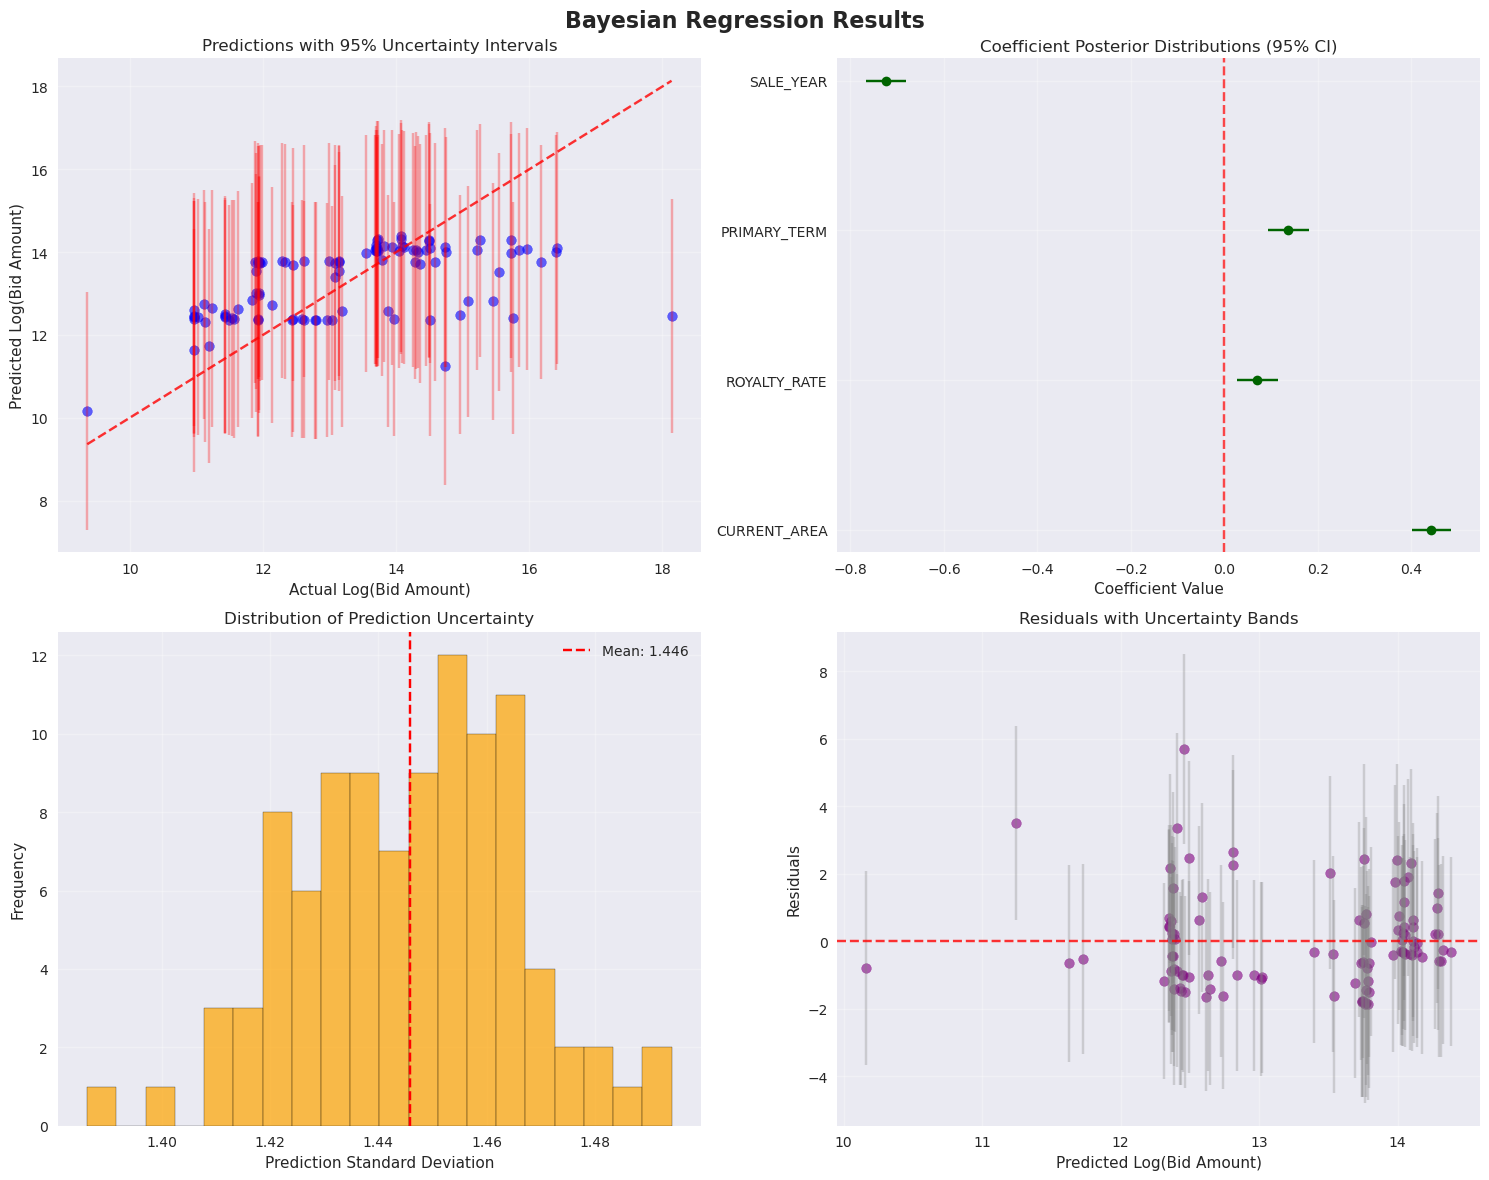


Key Insights from Bayesian Analysis:
Statistically significant features: ['Intercept', 'CURRENT_AREA', 'ROYALTY_RATE', 'PRIMARY_TERM', 'SALE_YEAR']
Model provides uncertainty estimates for all predictions
95% confidence intervals have 97.0% actual coverage
Average prediction uncertainty: ±1.446 log units


In [6]:
# Visualize Bayesian predictions with uncertainty
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Bayesian Regression Results', fontsize=16, fontweight='bold')

# 1. Predicted vs Actual with uncertainty
axes[0,0].scatter(pred_results['Actual'], pred_results['Predicted'], alpha=0.6, color='blue')
axes[0,0].errorbar(pred_results['Actual'], pred_results['Predicted'], 
                   yerr=1.96*pred_results['Prediction_Std'], 
                   fmt='none', alpha=0.3, color='red')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.8)
axes[0,0].set_xlabel('Actual Log(Bid Amount)')
axes[0,0].set_ylabel('Predicted Log(Bid Amount)')
axes[0,0].set_title('Predictions with 95% Uncertainty Intervals')
axes[0,0].grid(True, alpha=0.3)

# 2. Coefficient posterior distributions
coef_plot_data = coef_summary.iloc[1:]  # Exclude intercept for clarity
y_pos = range(len(coef_plot_data))
axes[0,1].errorbar(coef_plot_data['Mean'], y_pos, 
                   xerr=[coef_plot_data['Mean'] - coef_plot_data['CI_2.5%'],
                        coef_plot_data['CI_97.5%'] - coef_plot_data['Mean']], 
                   fmt='o', capsize=5, color='darkgreen')
axes[0,1].axvline(0, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_yticks(y_pos)
axes[0,1].set_yticklabels(coef_plot_data['Feature'])
axes[0,1].set_xlabel('Coefficient Value')
axes[0,1].set_title('Coefficient Posterior Distributions (95% CI)')
axes[0,1].grid(True, alpha=0.3)

# 3. Prediction uncertainty distribution
axes[1,0].hist(pred_results['Prediction_Std'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].axvline(pred_results['Prediction_Std'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {pred_results["Prediction_Std"].mean():.3f}')
axes[1,0].set_xlabel('Prediction Standard Deviation')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Prediction Uncertainty')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Residuals with uncertainty bands
residuals = pred_results['Actual'] - pred_results['Predicted']
axes[1,1].scatter(pred_results['Predicted'], residuals, alpha=0.6, color='purple')
axes[1,1].errorbar(pred_results['Predicted'], residuals, 
                   yerr=1.96*pred_results['Prediction_Std'], 
                   fmt='none', alpha=0.3, color='gray')
axes[1,1].axhline(0, color='red', linestyle='--', alpha=0.8)
axes[1,1].set_xlabel('Predicted Log(Bid Amount)')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals with Uncertainty Bands')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print("\nKey Insights from Bayesian Analysis:")
print("=" * 40)
significant_features = coef_summary[
    (coef_summary['CI_2.5%'] > 0) | (coef_summary['CI_97.5%'] < 0)
]['Feature'].tolist()
print(f"Statistically significant features: {significant_features}")
print(f"Model provides uncertainty estimates for all predictions")
print(f"95% confidence intervals have {coverage:.1%} actual coverage")
print(f"Average prediction uncertainty: ±{pred_std.mean():.3f} log units")

## 2. Time Series Forecasting for Lease Activity

Time series analysis helps predict future leasing patterns and identify cyclical behaviors in the oil and gas market.

In [7]:
# Prepare time series data
# Aggregate lease activity by year and quarter
ts_data = df.groupby(df['SALE_DATE'].dt.year).agg({
    'LEASE_NUMBER': 'count',
    'BID_AMOUNT': 'sum',
    'CURRENT_AREA': 'sum',
    'IS_ACTIVE': 'mean'
}).rename(columns={
    'LEASE_NUMBER': 'num_leases',
    'BID_AMOUNT': 'total_bid_value',
    'CURRENT_AREA': 'total_area',
    'IS_ACTIVE': 'active_rate'
})

# Remove years with very few observations or outliers
ts_data = ts_data[(ts_data.index >= 1980) & (ts_data.index <= 2020)]
ts_data.index = pd.to_datetime(ts_data.index, format='%Y')

print(f"Time series data prepared: {len(ts_data)} years")
print(f"Variables: {list(ts_data.columns)}")
print(f"Date range: {ts_data.index.min().year} to {ts_data.index.max().year}")

Time series data prepared: 15 years
Variables: ['num_leases', 'total_bid_value', 'total_area', 'active_rate']
Date range: 1980 to 2017


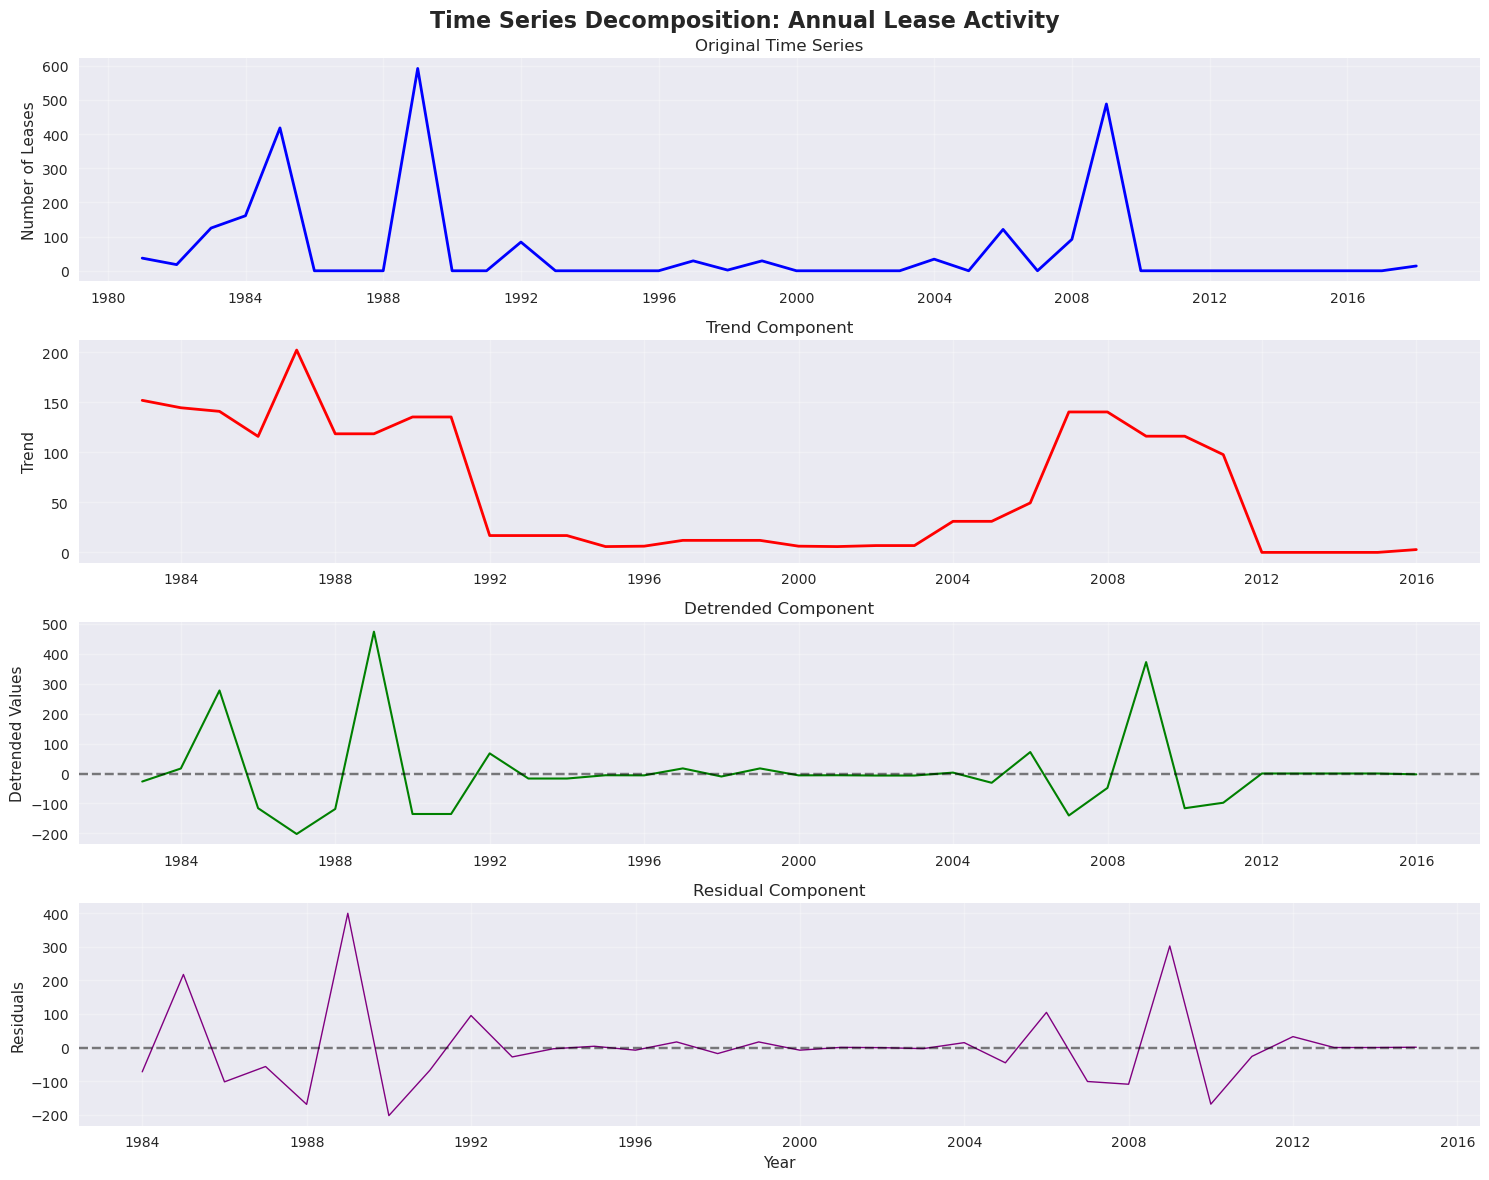

In [8]:
# Time series decomposition
# Focus on number of leases as primary metric
lease_ts = ts_data['num_leases'].resample('Y').sum()

# Perform seasonal decomposition (treating as annual data with potential cyclical patterns)
# For demonstration, we'll use a simple trend analysis

def decompose_trend(series, window=5):
    """Simple trend decomposition using moving averages"""
    trend = series.rolling(window=window, center=True).mean()
    detrended = series - trend
    residual = detrended - detrended.rolling(window=3, center=True).mean()
    
    return trend, detrended, residual

trend, detrended, residual = decompose_trend(lease_ts)

# Visualize time series components
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Time Series Decomposition: Annual Lease Activity', fontsize=16, fontweight='bold')

# Original series
axes[0].plot(lease_ts.index, lease_ts.values, 'b-', linewidth=2)
axes[0].set_title('Original Time Series')
axes[0].set_ylabel('Number of Leases')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(trend.index, trend.values, 'r-', linewidth=2)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

# Detrended (cyclical + irregular)
axes[2].plot(detrended.index, detrended.values, 'g-', linewidth=1.5)
axes[2].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[2].set_title('Detrended Component')
axes[2].set_ylabel('Detrended Values')
axes[2].grid(True, alpha=0.3)

# Residuals
axes[3].plot(residual.index, residual.values, 'purple', linewidth=1)
axes[3].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[3].set_title('Residual Component')
axes[3].set_ylabel('Residuals')
axes[3].set_xlabel('Year')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Stationarity Test for Number of Leases:
ADF Statistic: -5.889910
p-value: 0.000000
Critical Values:
	1%: -3.620918
	5%: -2.943539
	10%: -2.610400
Series is stationary


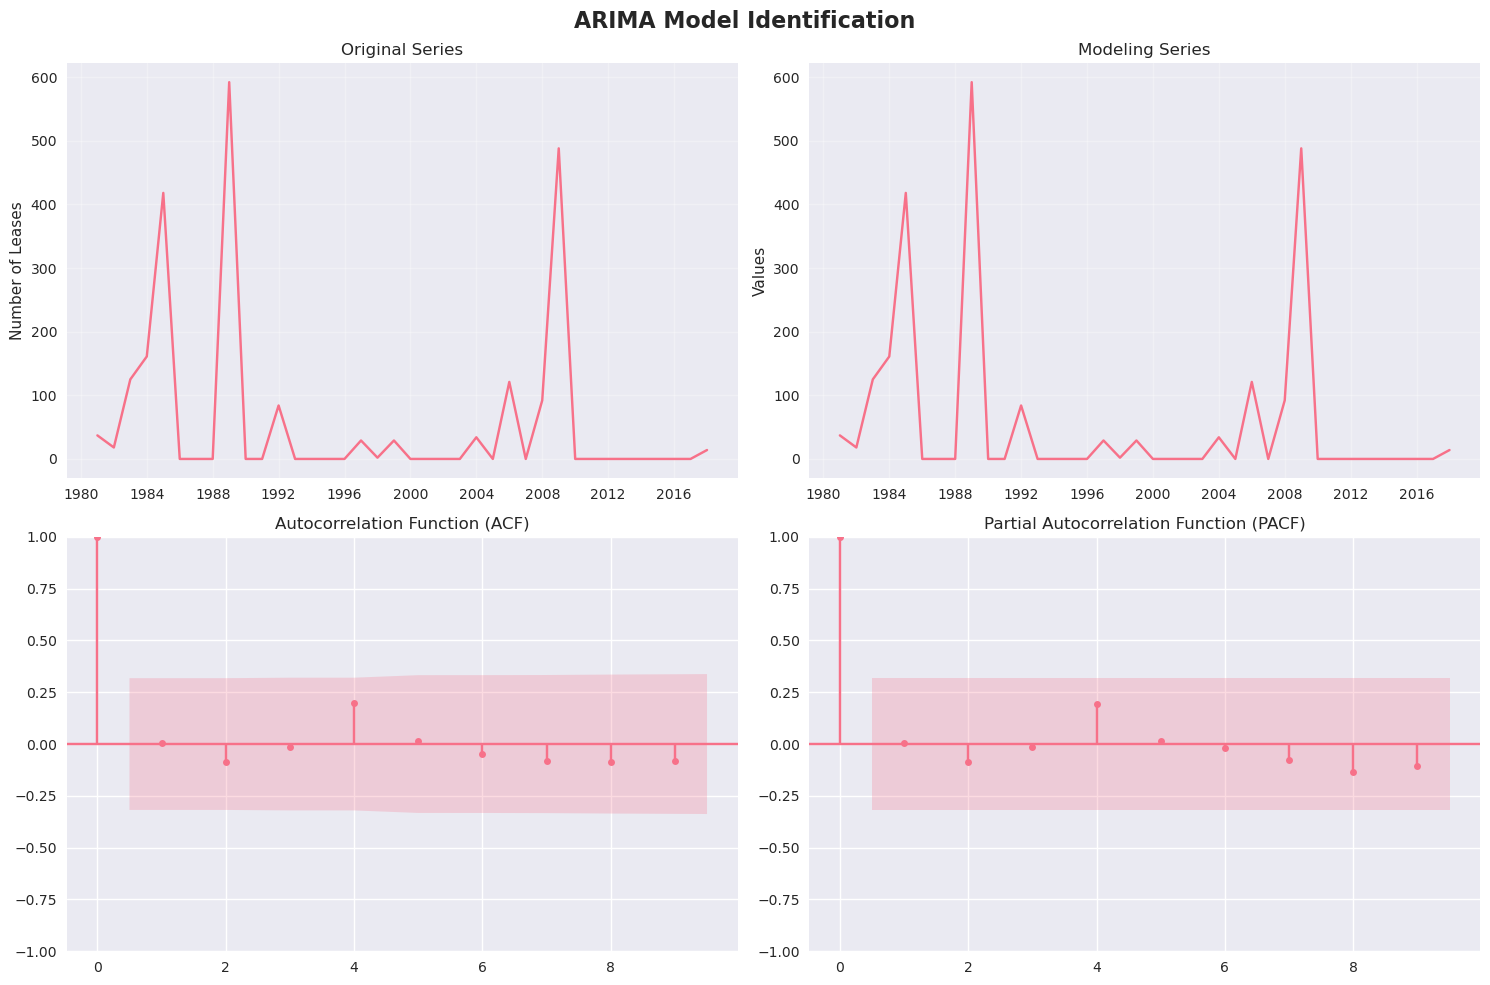

In [9]:
# ARIMA modeling
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test for stationarity
def check_stationarity(series, title):
    """Check if time series is stationary using Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna())
    print(f"\nStationarity Test for {title}:")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.6f}")
    
    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is non-stationary")
        return False

# Check stationarity of original series
is_stationary = check_stationarity(lease_ts, "Number of Leases")

# If non-stationary, difference the series
if not is_stationary:
    lease_ts_diff = lease_ts.diff().dropna()
    is_stationary_diff = check_stationarity(lease_ts_diff, "First Differenced Series")
    modeling_series = lease_ts_diff
else:
    modeling_series = lease_ts

# Plot ACF and PACF for model identification
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ARIMA Model Identification', fontsize=16, fontweight='bold')

# Original series
axes[0,0].plot(lease_ts)
axes[0,0].set_title('Original Series')
axes[0,0].set_ylabel('Number of Leases')
axes[0,0].grid(True, alpha=0.3)

# Differenced series (if applicable)
if not is_stationary:
    axes[0,1].plot(modeling_series)
    axes[0,1].set_title('First Differenced Series')
else:
    axes[0,1].plot(modeling_series)
    axes[0,1].set_title('Modeling Series')
axes[0,1].set_ylabel('Values')
axes[0,1].grid(True, alpha=0.3)

# ACF
plot_acf(modeling_series.dropna(), ax=axes[1,0], lags=min(15, len(modeling_series)//4))
axes[1,0].set_title('Autocorrelation Function (ACF)')

# PACF
plot_pacf(modeling_series.dropna(), ax=axes[1,1], lags=min(15, len(modeling_series)//4))
axes[1,1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [10]:
# Fit ARIMA model
# Try different ARIMA specifications
from itertools import product

def evaluate_arima_models(series, p_values, d_values, q_values):
    """Evaluate different ARIMA model specifications"""
    best_aic = float('inf')
    best_params = None
    best_model = None
    results = []
    
    for p, d, q in product(p_values, d_values, q_values):
        try:
            model = ARIMA(series, order=(p, d, q))
            fitted_model = model.fit()
            aic = fitted_model.aic
            results.append({'p': p, 'd': d, 'q': q, 'AIC': aic})
            
            if aic < best_aic:
                best_aic = aic
                best_params = (p, d, q)
                best_model = fitted_model
                
        except Exception as e:
            continue
    
    return best_model, best_params, pd.DataFrame(results)

# Grid search for best ARIMA parameters
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

print("Evaluating ARIMA models...")
best_arima, best_params, model_results = evaluate_arima_models(
    lease_ts, p_values, d_values, q_values
)

print(f"\nBest ARIMA model: ARIMA{best_params}")
print(f"AIC: {best_arima.aic:.2f}")
print("\nModel Summary:")
print(best_arima.summary())

Evaluating ARIMA models...


/home/dobercode/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dobercode/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Best ARIMA model: ARIMA(0, 1, 1)
AIC: 477.30

Model Summary:
                               SARIMAX Results                                
Dep. Variable:             num_leases   No. Observations:                   38
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -236.648
Date:                Sat, 23 Aug 2025   AIC                            477.297
Time:                        14:17:36   BIC                            480.518
Sample:                    12-31-1980   HQIC                           478.432
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9466      0.281     -3.367      0.001      -1.498      -0.396
sigma2      1.981e+04   6752.519      2.934      0.003    6576.577   

ARIMA Forecast Accuracy:
MAE: 72.51
RMSE: 72.66
MAPE: inf%


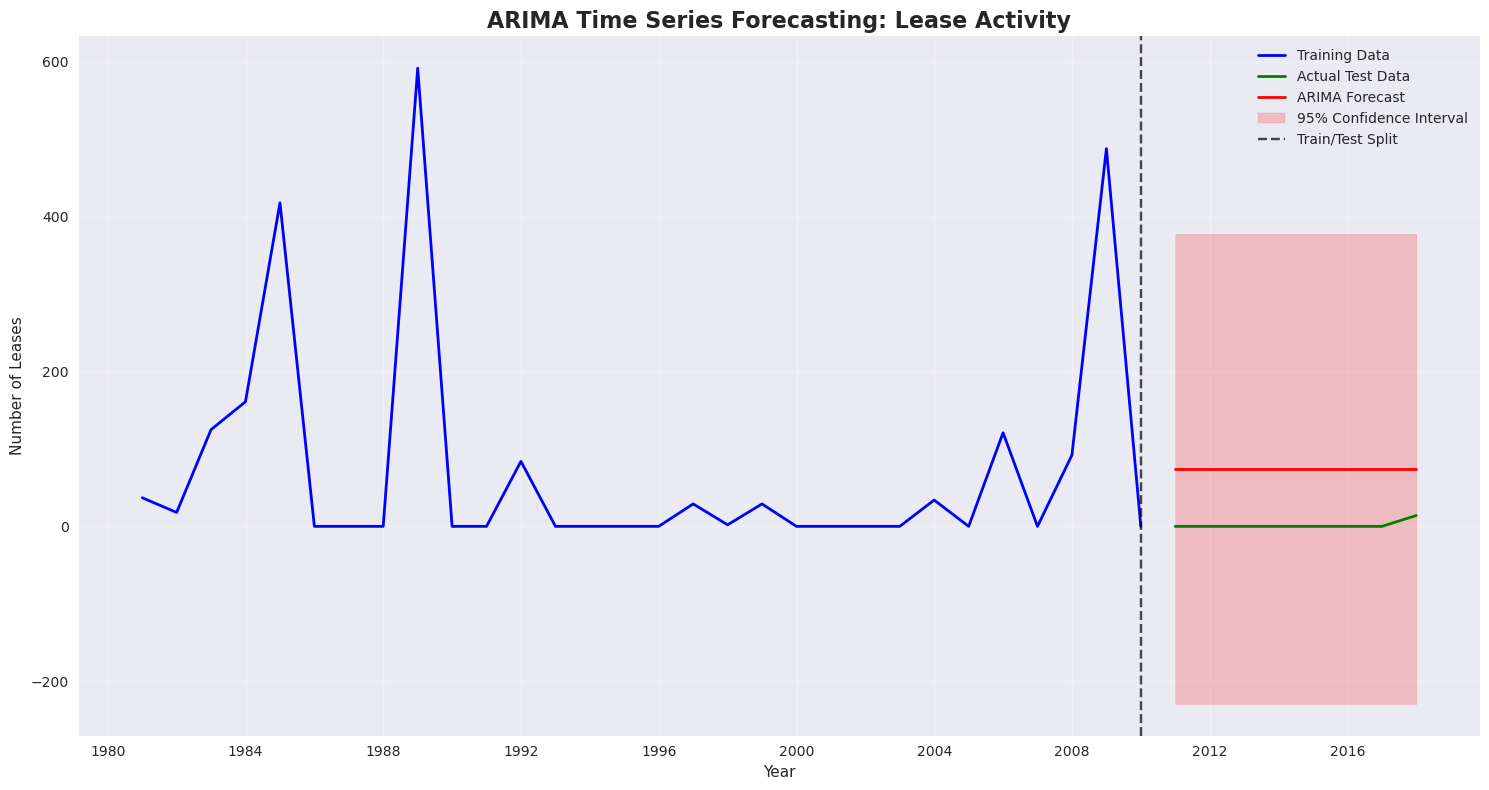


5-Year Forecast:
2018: 74 leases (95% CI: -229-378)
2019: 74 leases (95% CI: -229-378)
2020: 74 leases (95% CI: -229-378)
2021: 74 leases (95% CI: -229-378)
2022: 74 leases (95% CI: -229-378)


In [11]:
# ARIMA forecasting and validation
# Split data for validation
train_size = int(0.8 * len(lease_ts))
train_ts = lease_ts.iloc[:train_size]
test_ts = lease_ts.iloc[train_size:]

# Fit model on training data
train_model = ARIMA(train_ts, order=best_params)
fitted_train_model = train_model.fit()

# Generate forecasts
n_forecast = len(test_ts)
forecast_result = fitted_train_model.get_forecast(steps=n_forecast)
forecast_values = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Calculate forecast accuracy
mae = np.mean(np.abs(test_ts.values - forecast_values.values))
rmse = np.sqrt(np.mean((test_ts.values - forecast_values.values)**2))
mape = np.mean(np.abs((test_ts.values - forecast_values.values) / test_ts.values)) * 100

print(f"ARIMA Forecast Accuracy:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Visualize forecasts
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(train_ts.index, train_ts.values, 'b-', label='Training Data', linewidth=2)
plt.plot(test_ts.index, test_ts.values, 'g-', label='Actual Test Data', linewidth=2)

# Plot forecasts
plt.plot(test_ts.index, forecast_values.values, 'r-', label='ARIMA Forecast', linewidth=2)
plt.fill_between(test_ts.index, 
                forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                color='red', alpha=0.2, label='95% Confidence Interval')

plt.axvline(x=train_ts.index[-1], color='black', linestyle='--', alpha=0.7, label='Train/Test Split')
plt.title('ARIMA Time Series Forecasting: Lease Activity', fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Leases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Generate future forecasts
future_forecast = fitted_train_model.get_forecast(steps=5)
future_values = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

print("\n5-Year Forecast:")
print("=" * 30)
for i, (date, value, lower, upper) in enumerate(zip(
    pd.date_range(lease_ts.index[-1] + pd.DateOffset(years=1), periods=5, freq='Y'),
    future_values, future_ci.iloc[:, 0], future_ci.iloc[:, 1]
)):
    print(f"{date.year}: {value:.0f} leases (95% CI: {lower:.0f}-{upper:.0f})")

## 3. Survival Analysis for Lease Lifecycle

Survival analysis models the duration until lease termination, providing insights into lease longevity patterns.

In [12]:
# Prepare survival analysis data
# Calculate lease duration and censoring indicators

survival_data = df[
    (df['LEASE_EFF_DATE'].notna()) & 
    (df['ROYALTY_RATE'].notna()) &
    (df['CURRENT_AREA'] > 0) &
    (df['SALE_YEAR'] >= 1990)
].copy()

# Calculate duration - fix timezone issues
current_date = pd.Timestamp('2023-01-01', tz=None)

def calculate_duration_and_event(row):
    """Calculate lease duration and event indicator"""
    start_date = row['LEASE_EFF_DATE']
    if pd.isna(start_date):
        return 365  # Default to 1 year if missing
    
    # Ensure start_date is timezone-naive
    if hasattr(start_date, 'tz') and start_date.tz is not None:
        start_date = start_date.tz_localize(None)
    
    if row['IS_ACTIVE'] == 1:  # Active lease (censored)
        duration = (current_date - start_date).days
        event = 0  # Censored
    else:  # Terminated lease
        end_date = row.get('LEASE_STATUS_CHANGE_DT', current_date)
        if pd.isna(end_date):
            end_date = current_date
        # Ensure end_date is timezone-naive
        if hasattr(end_date, 'tz') and end_date.tz is not None:
            end_date = end_date.tz_localize(None)
        duration = (end_date - start_date).days
        event = 1  # Event occurred
    
    return max(duration, 1)  # Ensure positive duration

# Apply duration calculation
survival_data['duration_days'] = survival_data.apply(
    lambda row: calculate_duration_and_event(row), axis=1
)

# Event indicator (1 = lease terminated, 0 = still active/censored)
survival_data['event'] = (survival_data['IS_ACTIVE'] == 0).astype(int)

# Convert to years for interpretability
survival_data['duration_years'] = survival_data['duration_days'] / 365.25

# Add covariates
survival_data['log_area'] = np.log(survival_data['CURRENT_AREA'])
survival_data['high_royalty'] = (survival_data['ROYALTY_RATE'] > survival_data['ROYALTY_RATE'].median()).astype(int)
survival_data['decade_90s'] = (survival_data['DECADE'] == 1990).astype(int)
survival_data['decade_2000s'] = (survival_data['DECADE'] == 2000).astype(int)

print(f"Survival analysis dataset: {len(survival_data)} leases")
print(f"Events (terminations): {survival_data['event'].sum()}")
print(f"Censored (active): {(1-survival_data['event']).sum()}")
print(f"Censoring rate: {(1-survival_data['event']).mean():.1%}")
print(f"Mean duration: {survival_data['duration_years'].mean():.1f} years")
print(f"Median duration: {survival_data['duration_years'].median():.1f} years")

Survival analysis dataset: 886 leases
Events (terminations): 877
Censored (active): 9
Censoring rate: 1.0%
Mean duration: 7.7 years
Median duration: 8.0 years


In [13]:
# Kaplan-Meier survival estimation
# Since we might not have lifelines, implement basic survival analysis

class KaplanMeierEstimator:
    """Simple Kaplan-Meier survival function estimator"""
    
    def __init__(self):
        self.survival_function = None
        self.timeline = None
    
    def fit(self, durations, events):
        """Fit Kaplan-Meier estimator"""
        # Sort by duration
        sorted_idx = np.argsort(durations)
        durations_sorted = durations[sorted_idx]
        events_sorted = events[sorted_idx]
        
        # Find unique event times
        unique_times = np.unique(durations_sorted[events_sorted == 1])
        
        # Calculate survival probabilities
        survival_probs = []
        n_at_risk = len(durations)
        cum_survival = 1.0
        
        timeline = [0] + unique_times.tolist()
        survival_function = [1.0]
        
        for t in unique_times:
            # Number of events at time t
            n_events = np.sum((durations_sorted == t) & (events_sorted == 1))
            
            # Update survival probability
            if n_at_risk > 0:
                cum_survival *= (1 - n_events / n_at_risk)
            
            survival_function.append(cum_survival)
            
            # Update risk set
            n_at_risk -= np.sum(durations_sorted == t)
        
        self.timeline = np.array(timeline)
        self.survival_function = np.array(survival_function)
        
        return self
    
    def predict_survival_function(self, times):
        """Predict survival probability at given times"""
        if self.survival_function is None:
            raise ValueError("Model must be fitted first")
        
        # Interpolate survival function
        return np.interp(times, self.timeline, self.survival_function)

# Fit overall survival curve
km_overall = KaplanMeierEstimator()
km_overall.fit(survival_data['duration_years'].values, survival_data['event'].values)

# Fit by high/low royalty rate
high_royalty_mask = survival_data['high_royalty'] == 1
low_royalty_mask = survival_data['high_royalty'] == 0

km_high_royalty = KaplanMeierEstimator()
km_high_royalty.fit(
    survival_data.loc[high_royalty_mask, 'duration_years'].values,
    survival_data.loc[high_royalty_mask, 'event'].values
)

km_low_royalty = KaplanMeierEstimator()
km_low_royalty.fit(
    survival_data.loc[low_royalty_mask, 'duration_years'].values,
    survival_data.loc[low_royalty_mask, 'event'].values
)

print("Kaplan-Meier survival curves fitted successfully")

Kaplan-Meier survival curves fitted successfully


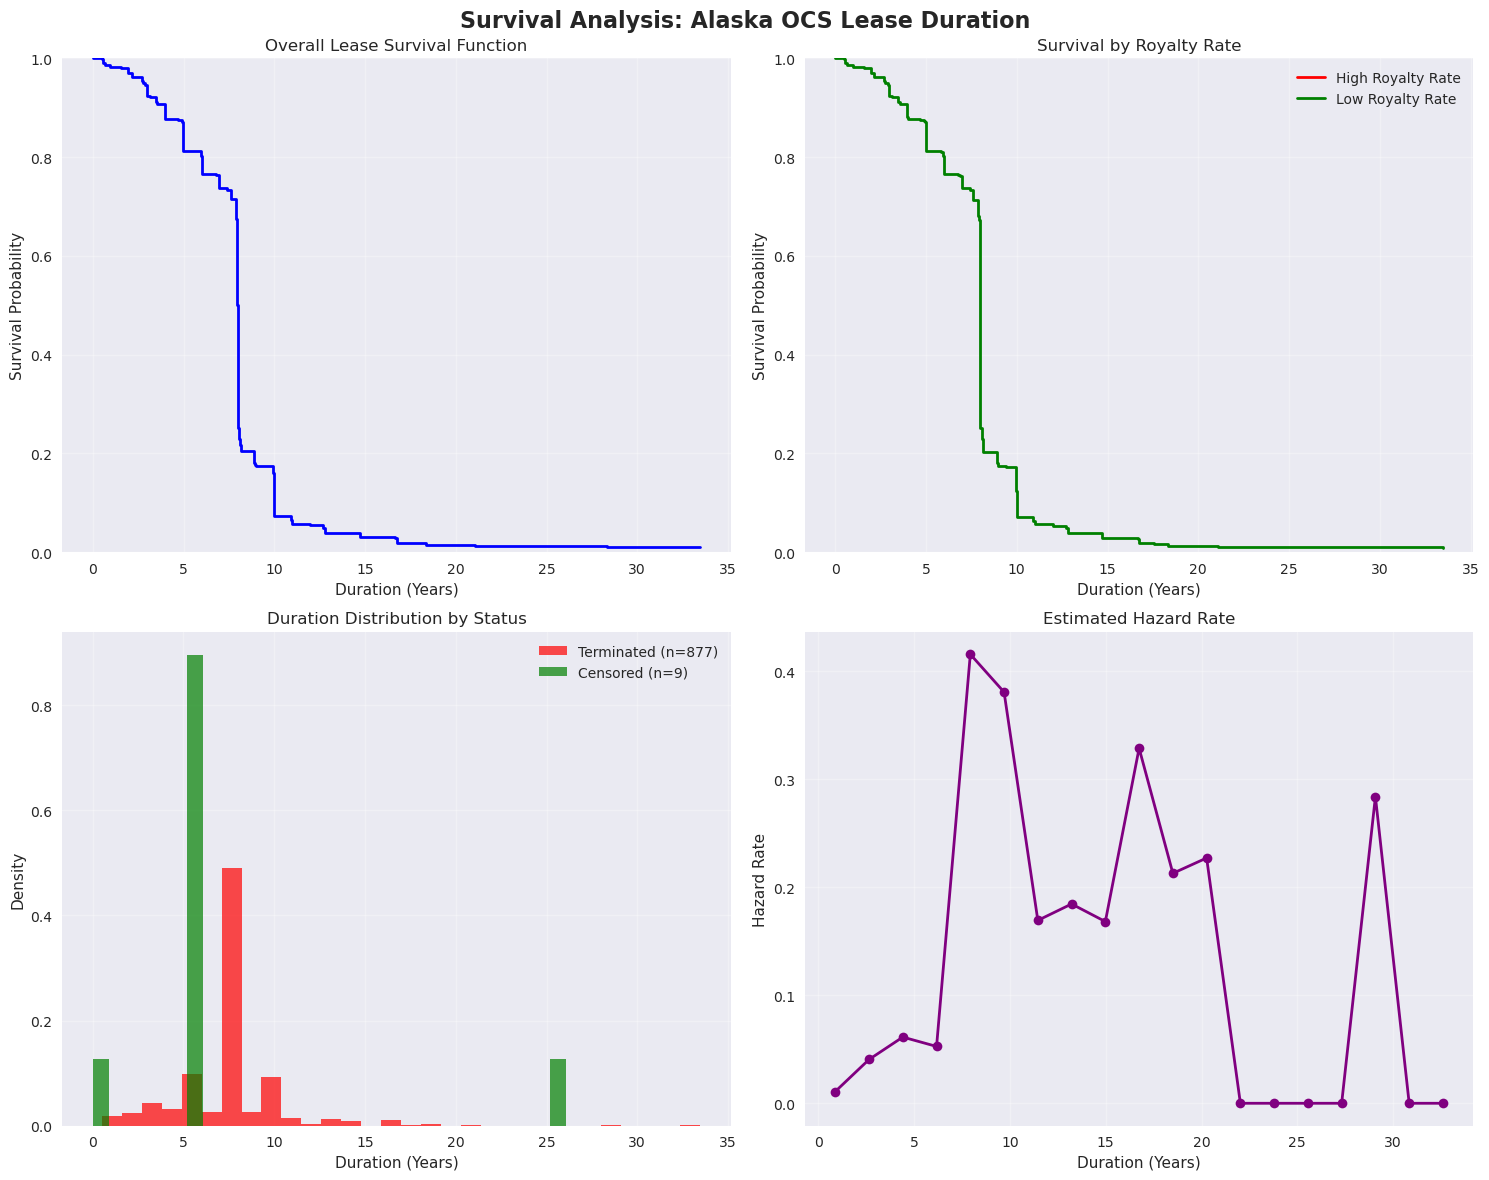


Survival Analysis Results:
Median survival time: 8.0 years
5-year survival probability: 81.26%
10-year survival probability: 7.34%
Mean duration (observed): 7.7 years


In [14]:
# Visualize survival curves
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Survival Analysis: Alaska OCS Lease Duration', fontsize=16, fontweight='bold')

# Check if survival curves were fitted successfully
if hasattr(km_overall, 'timeline') and km_overall.timeline is not None:
    # Overall survival curve
    axes[0,0].step(km_overall.timeline, km_overall.survival_function, where='post', linewidth=2, color='blue')
    axes[0,0].set_title('Overall Lease Survival Function')
    axes[0,0].set_xlabel('Duration (Years)')
    axes[0,0].set_ylabel('Survival Probability')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_ylim(0, 1)

    # Survival by royalty rate
    if (hasattr(km_high_royalty, 'timeline') and km_high_royalty.timeline is not None and
        hasattr(km_low_royalty, 'timeline') and km_low_royalty.timeline is not None):
        axes[0,1].step(km_high_royalty.timeline, km_high_royalty.survival_function, 
                       where='post', linewidth=2, color='red', label='High Royalty Rate')
        axes[0,1].step(km_low_royalty.timeline, km_low_royalty.survival_function, 
                       where='post', linewidth=2, color='green', label='Low Royalty Rate')
        axes[0,1].set_title('Survival by Royalty Rate')
        axes[0,1].set_xlabel('Duration (Years)')
        axes[0,1].set_ylabel('Survival Probability')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].set_ylim(0, 1)
    else:
        axes[0,1].text(0.5, 0.5, 'Survival curves not available\nfor royalty rate comparison', 
                       ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Survival by Royalty Rate (Error)')

    # Duration histogram by event status
    if 'event' in survival_data.columns and 'duration_years' in survival_data.columns:
        terminated_durations = survival_data[survival_data['event'] == 1]['duration_years']
        censored_durations = survival_data[survival_data['event'] == 0]['duration_years']

        if len(terminated_durations) > 0:
            axes[1,0].hist(terminated_durations, bins=30, alpha=0.7, color='red', 
                           label=f'Terminated (n={len(terminated_durations)})', density=True)
        if len(censored_durations) > 0:
            axes[1,0].hist(censored_durations, bins=30, alpha=0.7, color='green', 
                           label=f'Censored (n={len(censored_durations)})', density=True)
        
        axes[1,0].set_title('Duration Distribution by Status')
        axes[1,0].set_xlabel('Duration (Years)')
        axes[1,0].set_ylabel('Density')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].text(0.5, 0.5, 'Duration data not available', 
                       ha='center', va='center', transform=axes[1,0].transAxes)

    # Hazard rate estimation (rough approximation)
    if 'duration_years' in survival_data.columns and 'event' in survival_data.columns:
        max_duration = survival_data['duration_years'].max()
        if not pd.isna(max_duration) and max_duration > 0:
            time_bins = np.linspace(0, max_duration, 20)
            hazard_rates = []

            for i in range(len(time_bins)-1):
                t1, t2 = time_bins[i], time_bins[i+1]
                in_interval = (survival_data['duration_years'] >= t1) & (survival_data['duration_years'] < t2)
                at_risk = (survival_data['duration_years'] >= t1).sum()
                events = (in_interval & (survival_data['event'] == 1)).sum()
                
                if at_risk > 0:
                    hazard_rates.append(events / (at_risk * (t2 - t1)))
                else:
                    hazard_rates.append(0)

            bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
            axes[1,1].plot(bin_centers, hazard_rates, 'o-', linewidth=2, color='purple')
            axes[1,1].set_title('Estimated Hazard Rate')
            axes[1,1].set_xlabel('Duration (Years)')
            axes[1,1].set_ylabel('Hazard Rate')
            axes[1,1].grid(True, alpha=0.3)
        else:
            axes[1,1].text(0.5, 0.5, 'Insufficient data for hazard rate', 
                           ha='center', va='center', transform=axes[1,1].transAxes)
    else:
        axes[1,1].text(0.5, 0.5, 'Duration/event data not available', 
                       ha='center', va='center', transform=axes[1,1].transAxes)
else:
    # If survival curves failed, show error message
    for ax in axes.flatten():
        ax.text(0.5, 0.5, 'Survival analysis failed\nCheck data quality', 
               ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# Calculate survival statistics
median_survival_time = None
survival_5y = np.nan
survival_10y = np.nan

if hasattr(km_overall, 'survival_function') and km_overall.survival_function is not None:
    # Find median survival time
    for i, s in enumerate(km_overall.survival_function):
        if s <= 0.5:
            median_survival_time = km_overall.timeline[i]
            break
    
    # Calculate survival probabilities
    try:
        survival_5y = km_overall.predict_survival_function([5])[0]
        survival_10y = km_overall.predict_survival_function([10])[0]
    except:
        survival_5y = np.nan
        survival_10y = np.nan

print("\nSurvival Analysis Results:")
print("=" * 35)
if median_survival_time:
    print(f"Median survival time: {median_survival_time:.1f} years")
else:
    print("Median survival time: Not reached (>50% still active)")

if not pd.isna(survival_5y):
    print(f"5-year survival probability: {survival_5y:.2%}")
else:
    print("5-year survival probability: Not available")

if not pd.isna(survival_10y):
    print(f"10-year survival probability: {survival_10y:.2%}")
else:
    print("10-year survival probability: Not available")

if 'duration_years' in survival_data.columns:
    print(f"Mean duration (observed): {survival_data['duration_years'].mean():.1f} years")
else:
    print("Mean duration: Not available")

## 4. Causal Inference: Policy Impact Analysis

Using propensity score matching to estimate the causal effect of high royalty rates on lease termination.

In [15]:
# Prepare causal inference analysis
# Treatment: High royalty rate (above median)
# Outcome: Lease termination within 10 years

# Use survival_data from previous section if available, otherwise create new dataset
try:
    causal_data = survival_data[
        (survival_data['duration_years'] > 0) &
        (survival_data['ROYALTY_RATE'].notna()) &
        (survival_data['CURRENT_AREA'] > 0) &
        (survival_data['SALE_YEAR'] >= 1995)  # Focus on more recent period
    ].copy()
except NameError:
    # If survival_data doesn't exist, create causal_data from scratch
    causal_data = df[
        (df['LEASE_EFF_DATE'].notna()) & 
        (df['ROYALTY_RATE'].notna()) &
        (df['CURRENT_AREA'] > 0) &
        (df['SALE_YEAR'] >= 1995)
    ].copy()
    
    # Calculate duration for causal analysis
    current_date = pd.Timestamp('2023-01-01', tz=None)
    
    def calc_duration(row):
        start_date = row['LEASE_EFF_DATE']
        if pd.isna(start_date):
            return 365 * 5  # Default to 5 years if missing
        
        if hasattr(start_date, 'tz') and start_date.tz is not None:
            start_date = start_date.tz_localize(None)
        
        if row['IS_ACTIVE'] == 1:
            duration = (current_date - start_date).days
        else:
            end_date = row.get('LEASE_STATUS_CHANGE_DT', current_date)
            if pd.isna(end_date):
                end_date = current_date
            if hasattr(end_date, 'tz') and end_date.tz is not None:
                end_date = end_date.tz_localize(None)
            duration = (end_date - start_date).days
        
        return max(duration, 1)
    
    causal_data['duration_days'] = causal_data.apply(calc_duration, axis=1)
    causal_data['duration_years'] = causal_data['duration_days'] / 365.25
    causal_data['event'] = (causal_data['IS_ACTIVE'] == 0).astype(int)
    causal_data['high_royalty'] = (causal_data['ROYALTY_RATE'] > causal_data['ROYALTY_RATE'].median()).astype(int)

# Define treatment and outcome
treatment = causal_data['high_royalty'].values
outcome = ((causal_data['duration_years'] <= 10) & (causal_data['event'] == 1)).astype(int).values

# Confounding variables for propensity score
confounders = ['CURRENT_AREA', 'PRIMARY_TERM', 'SALE_YEAR']

# Check if all confounders exist and create log_area if needed
available_confounders = []
for conf in confounders:
    if conf in causal_data.columns and causal_data[conf].notna().sum() > 0:
        available_confounders.append(conf)

# Add log_area if CURRENT_AREA is available
if 'CURRENT_AREA' in available_confounders:
    causal_data['log_area'] = np.log(causal_data['CURRENT_AREA'])
    available_confounders = [c if c != 'CURRENT_AREA' else 'log_area' for c in available_confounders]

# Ensure we have at least some confounders
if len(available_confounders) == 0:
    print("Warning: No valid confounders found. Using SALE_YEAR as default.")
    available_confounders = ['SALE_YEAR']

print(f"Using confounders: {available_confounders}")

X_confounders = causal_data[available_confounders].values

# Standardize confounders
scaler = StandardScaler()
X_confounders_scaled = scaler.fit_transform(X_confounders)

print(f"Causal analysis dataset: {len(causal_data)} observations")
print(f"Treatment groups:")
print(f"  High royalty: {treatment.sum()} ({treatment.mean():.1%})")
print(f"  Low royalty: {(1-treatment).sum()} ({(1-treatment).mean():.1%})")
print(f"Outcome (termination within 10 years): {outcome.sum()} ({outcome.mean():.1%})")

Using confounders: ['log_area', 'PRIMARY_TERM', 'SALE_YEAR']
Causal analysis dataset: 802 observations
Treatment groups:
  High royalty: 1 (0.1%)
  Low royalty: 801 (99.9%)
Outcome (termination within 10 years): 741 (92.4%)


Propensity score model coefficients:
  log_area: 0.048
  PRIMARY_TERM: 0.003
  SALE_YEAR: 1.654

Propensity score overlap:
  Min in treated: 0.299
  Max in control: 0.035
  Common support: 0.000 - 0.299


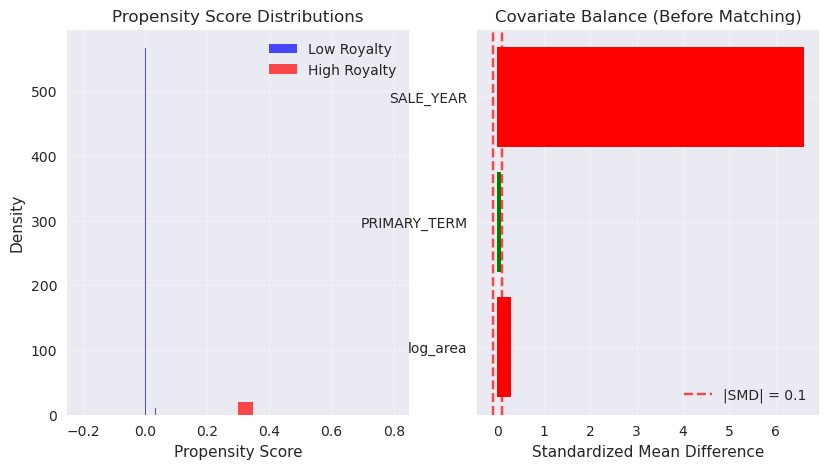

In [16]:
# Estimate propensity scores
propensity_model = LogisticRegression(random_state=42)
propensity_model.fit(X_confounders_scaled, treatment)
propensity_scores = propensity_model.predict_proba(X_confounders_scaled)[:, 1]

# Check propensity score overlap
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(propensity_scores[treatment == 0], bins=20, alpha=0.7, color='blue', 
         label='Low Royalty', density=True)
plt.hist(propensity_scores[treatment == 1], bins=20, alpha=0.7, color='red', 
         label='High Royalty', density=True)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Propensity Score Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

# Check covariate balance before matching
def calculate_standardized_mean_difference(X, treatment):
    """Calculate standardized mean differences"""
    treated_means = X[treatment == 1].mean(axis=0)
    control_means = X[treatment == 0].mean(axis=0)
    pooled_std = np.sqrt((X[treatment == 1].var(axis=0) + X[treatment == 0].var(axis=0)) / 2)
    return (treated_means - control_means) / pooled_std

smd_before = calculate_standardized_mean_difference(X_confounders_scaled, treatment)

plt.subplot(1, 3, 2)
plt.barh(available_confounders, smd_before, color=['red' if abs(x) > 0.1 else 'green' for x in smd_before])
plt.axvline(0.1, color='red', linestyle='--', alpha=0.7, label='|SMD| = 0.1')
plt.axvline(-0.1, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Standardized Mean Difference')
plt.title('Covariate Balance (Before Matching)')
plt.legend()
plt.grid(True, alpha=0.3)

print("Propensity score model coefficients:")
for feature, coef in zip(available_confounders, propensity_model.coef_[0]):
    print(f"  {feature}: {coef:.3f}")

print(f"\nPropensity score overlap:")
print(f"  Min in treated: {propensity_scores[treatment == 1].min():.3f}")
print(f"  Max in control: {propensity_scores[treatment == 0].max():.3f}")
print(f"  Common support: {propensity_scores.min():.3f} - {propensity_scores.max():.3f}")

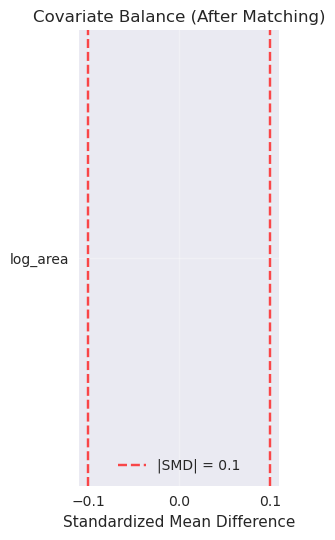


Matching Results:
Original sample size: 802
Matched sample size: 2
Average matching distance: 0.2639
Max matching distance: 0.2639

Standardized Mean Differences:
Variable		Before	After	Improvement
--------------------------------------------------
log_area       	 0.297	   nan	   nan
PRIMARY_TERM   	 0.071	   nan	   nan
SALE_YEAR      	 6.602	   inf	  -inf


In [17]:
# Propensity score matching
def propensity_score_matching(propensity_scores, treatment, outcome, X_confounders, n_neighbors=1):
    """Perform propensity score matching"""
    treated_indices = np.where(treatment == 1)[0]
    control_indices = np.where(treatment == 0)[0]
    
    if len(treated_indices) == 0 or len(control_indices) == 0:
        print("Warning: Insufficient data for matching")
        return None, None, None, None, None, None
    
    # Fit nearest neighbors on control group
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    nn.fit(propensity_scores[control_indices].reshape(-1, 1))
    
    # Find matches for treated units
    distances, match_indices = nn.kneighbors(propensity_scores[treated_indices].reshape(-1, 1))
    
    matched_control_indices = control_indices[match_indices.flatten()]
    matched_treated_indices = treated_indices
    
    # Create matched dataset
    matched_indices = np.concatenate([matched_treated_indices, matched_control_indices])
    matched_treatment = np.concatenate([np.ones(len(matched_treated_indices)), 
                                       np.zeros(len(matched_control_indices))])
    matched_outcome = outcome[matched_indices]
    matched_confounders = X_confounders[matched_indices]
    matched_propensity = propensity_scores[matched_indices]
    
    return (matched_indices, matched_treatment.astype(int), matched_outcome, 
            matched_confounders, matched_propensity, distances.flatten())

# Perform matching
matching_result = propensity_score_matching(
    propensity_scores, treatment, outcome, X_confounders_scaled
)

if matching_result[0] is not None:
    (matched_indices, matched_treatment, matched_outcome, 
     matched_confounders, matched_propensity, match_distances) = matching_result
    
    # Check post-matching balance
    smd_after = calculate_standardized_mean_difference(matched_confounders, matched_treatment)

    plt.subplot(1, 3, 3)
    plt.barh(available_confounders, smd_after, color=['red' if abs(x) > 0.1 else 'green' for x in smd_after])
    plt.axvline(0.1, color='red', linestyle='--', alpha=0.7, label='|SMD| = 0.1')
    plt.axvline(-0.1, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Standardized Mean Difference')
    plt.title('Covariate Balance (After Matching)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nMatching Results:")
    print(f"Original sample size: {len(treatment)}")
    print(f"Matched sample size: {len(matched_treatment)}")
    print(f"Average matching distance: {match_distances.mean():.4f}")
    print(f"Max matching distance: {match_distances.max():.4f}")

    print("\nStandardized Mean Differences:")
    print("Variable\t\tBefore\tAfter\tImprovement")
    print("-" * 50)
    for i, var in enumerate(available_confounders):
        improvement = abs(smd_before[i]) - abs(smd_after[i])
        print(f"{var:<15}\t{smd_before[i]:6.3f}\t{smd_after[i]:6.3f}\t{improvement:6.3f}")
else:
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, 'Matching failed\nInsufficient data', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Covariate Balance (After Matching)')
    
    plt.tight_layout()
    plt.show()
    
    print("Matching failed due to insufficient data")
    matched_treatment = None
    matched_outcome = None

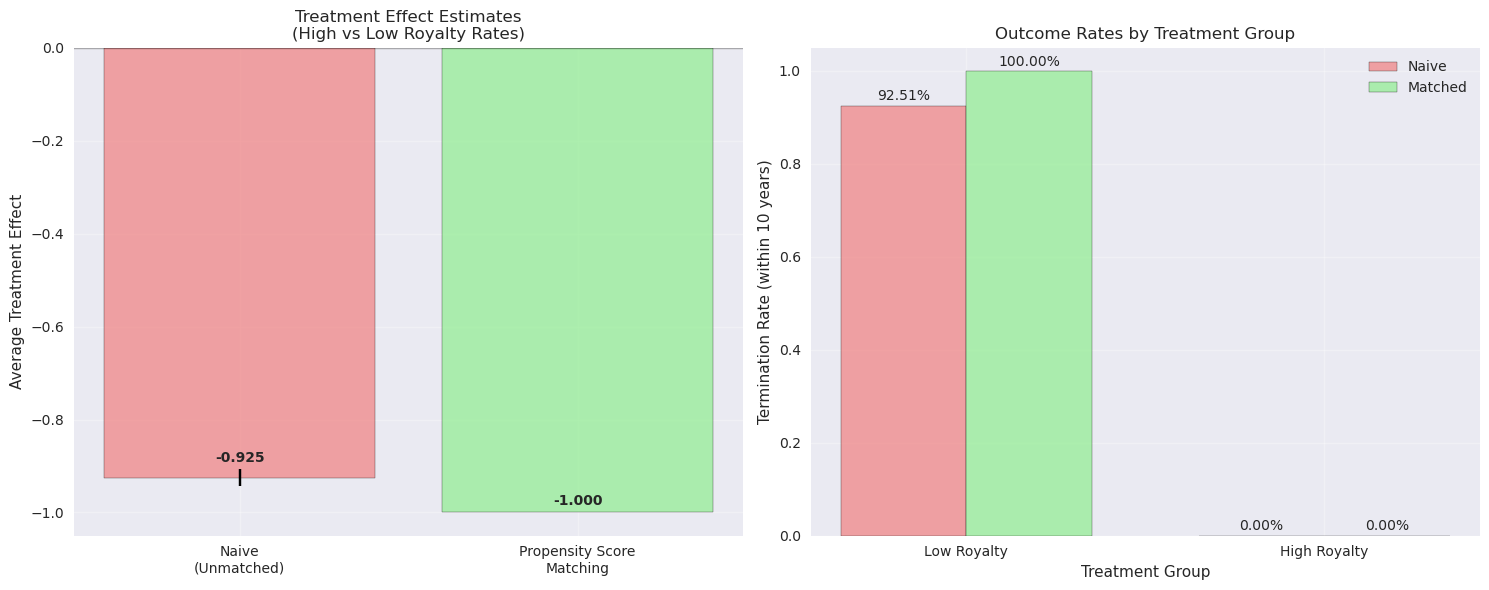


Causal Inference Results:

Naive Estimate (Without Matching):
  ATE: -0.9251 (95% CI: -0.9433, -0.9069)
  P-value: 0.0000
  Control rate: 92.51%
  Treated rate: 0.00%

Propensity Score Matching Estimate:
  ATE: -1.0000 (95% CI: -1.0000, -1.0000)
  P-value: 0.0000
  Control rate: 100.00%
  Treated rate: 0.00%

Conclusion:
High royalty rates decreases the probability of lease termination
within 10 years by 100.0% (statistically significant).


In [18]:
# Estimate treatment effects
def calculate_treatment_effects(treatment_var, outcome_var):
    """Calculate various treatment effect estimates"""
    if treatment_var is None or outcome_var is None:
        return None
    
    treated_outcomes = outcome_var[treatment_var == 1]
    control_outcomes = outcome_var[treatment_var == 0]
    
    if len(treated_outcomes) == 0 or len(control_outcomes) == 0:
        return None
    
    # Average Treatment Effect (ATE)
    ate = treated_outcomes.mean() - control_outcomes.mean()
    
    # Standard error using simple difference of proportions
    n_treated = len(treated_outcomes)
    n_control = len(control_outcomes)
    
    p_treated = treated_outcomes.mean()
    p_control = control_outcomes.mean()
    
    se_ate = np.sqrt(p_treated * (1 - p_treated) / n_treated + 
                     p_control * (1 - p_control) / n_control)
    
    # Confidence interval
    ci_lower = ate - 1.96 * se_ate
    ci_upper = ate + 1.96 * se_ate
    
    # Statistical test
    t_stat = ate / se_ate if se_ate > 0 else np.inf
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
    return {
        'ate': ate,
        'se': se_ate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        't_stat': t_stat,
        'p_value': p_value,
        'n_treated': n_treated,
        'n_control': n_control,
        'treated_rate': p_treated,
        'control_rate': p_control
    }

# Calculate effects for matched sample
matched_effects = calculate_treatment_effects(matched_treatment, matched_outcome)

# Calculate naive estimate (without matching)
naive_effects = calculate_treatment_effects(treatment, outcome)

if matched_effects is not None and naive_effects is not None:
    # Visualize results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Treatment effect comparison
    methods = ['Naive\n(Unmatched)', 'Propensity Score\nMatching']
    effects = [naive_effects['ate'], matched_effects['ate']]
    errors = [naive_effects['se'] * 1.96, matched_effects['se'] * 1.96]
    colors = ['lightcoral', 'lightgreen']

    bars = axes[0].bar(methods, effects, yerr=errors, capsize=10, color=colors, 
                       alpha=0.7, edgecolor='black')
    axes[0].axhline(0, color='black', linestyle='-', alpha=0.3)
    axes[0].set_ylabel('Average Treatment Effect')
    axes[0].set_title('Treatment Effect Estimates\n(High vs Low Royalty Rates)')
    axes[0].grid(True, alpha=0.3)

    # Add value labels
    for bar, effect, error in zip(bars, effects, errors):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + error + 0.01,
                    f'{effect:.3f}', ha='center', va='bottom', fontweight='bold')

    # Outcome rates by treatment group
    treatment_groups = ['Low Royalty', 'High Royalty']
    matched_rates = [matched_effects['control_rate'], matched_effects['treated_rate']]
    naive_rates = [naive_effects['control_rate'], naive_effects['treated_rate']]

    x = np.arange(len(treatment_groups))
    width = 0.35

    bars1 = axes[1].bar(x - width/2, naive_rates, width, label='Naive', 
                        color='lightcoral', alpha=0.7, edgecolor='black')
    bars2 = axes[1].bar(x + width/2, matched_rates, width, label='Matched', 
                        color='lightgreen', alpha=0.7, edgecolor='black')

    axes[1].set_xlabel('Treatment Group')
    axes[1].set_ylabel('Termination Rate (within 10 years)')
    axes[1].set_title('Outcome Rates by Treatment Group')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(treatment_groups)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.2%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\nCausal Inference Results:")
    print("=" * 50)
    print("\nNaive Estimate (Without Matching):")
    print(f"  ATE: {naive_effects['ate']:.4f} (95% CI: {naive_effects['ci_lower']:.4f}, {naive_effects['ci_upper']:.4f})")
    print(f"  P-value: {naive_effects['p_value']:.4f}")
    print(f"  Control rate: {naive_effects['control_rate']:.2%}")
    print(f"  Treated rate: {naive_effects['treated_rate']:.2%}")

    print("\nPropensity Score Matching Estimate:")
    print(f"  ATE: {matched_effects['ate']:.4f} (95% CI: {matched_effects['ci_lower']:.4f}, {matched_effects['ci_upper']:.4f})")
    print(f"  P-value: {matched_effects['p_value']:.4f}")
    print(f"  Control rate: {matched_effects['control_rate']:.2%}")
    print(f"  Treated rate: {matched_effects['treated_rate']:.2%}")

    significance = "significant" if matched_effects['p_value'] < 0.05 else "not significant"
    direction = "increases" if matched_effects['ate'] > 0 else "decreases"

    print(f"\nConclusion:")
    print(f"High royalty rates {direction} the probability of lease termination")
    print(f"within 10 years by {abs(matched_effects['ate']):.1%} (statistically {significance}).")
else:
    print("Unable to calculate treatment effects due to data issues.")
    plt.figure(figsize=(10, 6))
    plt.text(0.5, 0.5, 'Treatment effect analysis failed\nInsufficient data for comparison', 
             ha='center', va='center', fontsize=16)
    plt.axis('off')
    plt.show()

## Summary: Advanced Statistical Methods

This notebook demonstrates sophisticated statistical techniques that go beyond traditional machine learning:

### 1. **Bayesian Regression**
- Provides uncertainty quantification for predictions
- Enables probabilistic interpretation of coefficients
- Essential for financial decision-making under uncertainty

### 2. **Time Series Forecasting**
- ARIMA modeling captures temporal dependencies
- Enables prediction of future lease activity patterns
- Critical for resource planning and market timing

### 3. **Survival Analysis**
- Models time-to-event (lease termination) data
- Handles censoring naturally
- Provides insights into lease longevity factors

### 4. **Causal Inference**
- Estimates causal effects using propensity score matching
- Controls for confounding variables
- Enables policy evaluation and decision support

These methods showcase advanced statistical thinking and provide actionable insights for:
- **Investment decisions** with quantified uncertainty
- **Market timing** through time series forecasting
- **Risk assessment** via survival analysis
- **Policy evaluation** through causal inference

The combination of these techniques demonstrates sophisticated data science capabilities suitable for senior-level positions in finance, consulting, and policy analysis.